In [2]:
# Load our stuff
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
random.seed(1408)
import csv
from scipy.stats import ttest_1samp
import pandas as pd
import collections
# Load options

germline_sequence = "data/gpt.fasta"
germline =list(SeqIO.parse(germline_sequence, "fasta"))[0].seq

cm = ContextModel(3, 2, pkgutil.get_data("SHMModels", "data/aid_goodman.csv"))

pol_eta_params = {
            "A": [0.9, 0.02, 0.02, 0.06],
            "G": [0.01, 0.97, 0.01, 0.01],
            "C": [0.01, 0.01, 0.97, 0.01],
            "T": [0.06, 0.02, 0.02, 0.9],
        }
ber_params = np.array([0.25,0.25,0.25,0.25])


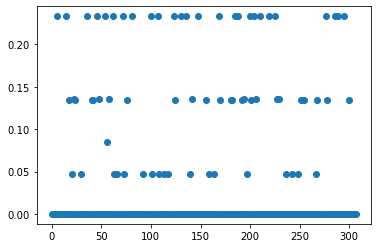

In [3]:
fw_contexts = np.zeros(308)
for i in range(308):
    fw_contexts[i] = cm.get_context_prob(i,germline)
plt.scatter(range(308),fw_contexts)


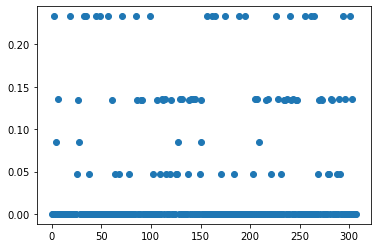

In [4]:
rc_contexts = np.zeros(308)
for i in range(308):
    rc_contexts[i] = cm.get_context_prob(i,germline.complement())
plt.scatter(range(308),rc_contexts)

In [5]:
subset = []
with open('subset.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        subset.append(row)


In [6]:
subset = subset[1:309]
seqs = []
for i in range(2242):
    seqs.append([k[i+1] for k in subset])
seqs = np.array(seqs)

In [7]:
inds = np.array([i=='C' or i == 'G' for i in germline])

In [8]:
mut_list = []
germ_mut_list = []
for i in range(2242):
    for j in range(308):
        if germline[j] != seqs[i,j]:
            mut_list.append(germline[j]+seqs[i,j])
            germ_mut_list.append(germline[j])

In [9]:
counter = collections.Counter(mut_list)

(array([0.12464169, 0.07562961, 0.04862817, 0.06142506, 0.12732903,
        0.19758395, 0.06552007, 0.07409398, 0.04594083, 0.08829853]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

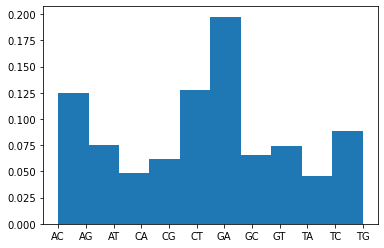

In [10]:
plt.hist(sorted(mut_list),density = True)

(array([75.,  0.,  0., 70.,  0.,  0., 89.,  0.,  0., 74.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

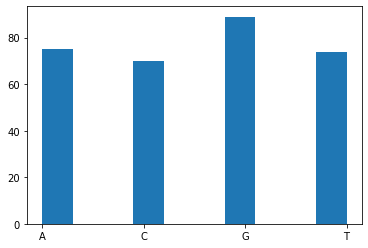

In [11]:
plt.hist(sorted(germline))

(array([1565.,    0.,    0., 1855.,    0.,    0., 2635.,    0.,    0.,
        1049.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

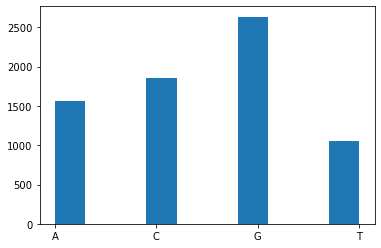

In [12]:
plt.hist(sorted(germ_mut_list))

In [13]:
def sample_prior():
    ls = np.random.uniform(low = -12.0, high = -2.0)
    sg = np.random.uniform(low = 5.0, high = 20.0)
    off = -10
    p_fw = np.random.uniform(low =0.0, high = 1.0)
    exo_left = np.random.uniform(low =0.0, high = 1.0)
    exo_right = np.random.uniform(low =0.0, high = 1.0)
    ber_prob = np.random.uniform(low = 0.0, high = 1.0)
    thinning_prob = norm.cdf(10.0/sg)
    fw_br = np.minimum(fw_contexts/(1.0-thinning_prob),1.0)
    rc_br = np.minimum(rc_contexts/(1.0-thinning_prob),1.0)
    return {           "lengthscale" : ls,
                       "gp_sigma" : sg,
                       "gp_ridge" : .01,
            "gp_offset": off,
            "p_fw": p_fw,
            "fw_br": fw_br,
            "rc_br": rc_br,
            "exo_left": exo_left,
            "exo_right": exo_right,
            "ber_prob": ber_prob
            }

# Get batch
def gen_batch_letters(seq,batch_size, params):
       # The prior specification
    ber_prob = params['ber_prob']
    ber_params = [0.25,0.25,0.25,0.25]
    
    bubble_size = 25.0
    pol_eta_params = {
        "A": [0.9, 0.02, 0.02, 0.06],
        "G": [0.01, 0.97, 0.01, 0.01],
        "C": [0.01, 0.01, 0.97, 0.01],
        "T": [0.06, 0.02, 0.02, 0.9],
    }
    prior_params = params
    exo_left = prior_params['exo_left']
    exo_right = prior_params['exo_right']
    mutated_seq_list = []
    for i in range(batch_size):
          mr = MutationRound(
          seq,
          ber_lambda=1.0,
          mmr_lambda=(1 - ber_prob)/ber_prob,
          replication_time=100,
          bubble_size=bubble_size,
          aid_time=10,
          exo_params={"left": exo_left, "right": exo_right},
          pol_eta_params=pol_eta_params,
          ber_params=ber_params,
          p_fw= prior_params['p_fw'],
          aid_context_model=cm,
          log_ls = prior_params['lengthscale'],
          sg = prior_params['gp_sigma'],
          fw_br = prior_params['fw_br'],
          rc_br = prior_params['rc_br'],
          off = prior_params['gp_offset']
          )
          mr.mutation_round()
          mutated_seq_list.append(SeqRecord(mr.repaired_sequence, id=""))
    return [list(i.seq) for i in mutated_seq_list]

In [14]:
prior = sample_prior()
thinning_prob = norm.cdf(10.0/prior['gp_sigma'])
thinning_prob
base_rates = np.minimum(fw_contexts/(1.0-thinning_prob),1.0)

In [15]:
def site_dist_colocal(seqs,germline,base_probs,dist):
    values = np.zeros(len(base_probs))
    vars = np.zeros(len(base_probs))
    for i in range(len(base_probs)-dist):
        if base_probs[i]*base_probs[i+dist]>0:
            p_1 = np.mean([z[i]!= germline[i] and z[i+dist]!=germline[i+dist] for z in seqs])
            p_2 = base_probs[i]
            p_3 = base_probs[i+dist]
            values[i] = p_1/(p_2*p_3)
            vars[i] = (1-p_2-p_3+p_2*p_3)/(len(seqs)*p_2*p_3)
        else:
            values[i] = 0.00
            vars[i] = 0.0
    return(values,vars)
def get_colocal(seqs,germline,base_probs, max_dist):
    colocals = np.zeros(max_dist)
    for i in range(max_dist):
        values,vars = site_dist_colocal(seqs,germline, base_probs, i+1)
        colocals[i] = np.nansum(values[values>0.0]/np.sqrt(vars[values>0.0]))/np.sum(1/np.sqrt(vars[vars>0.0]))
    return(colocals)

def gauss_kernel(x,y,eps):
    return np.exp(-(np.sum(np.square(x-y)))/(2*eps**2))

In [16]:
def shortestDistance(S, X):
 
    # Find distance from occurrences of X
    # appearing before current character.
    inf = float('inf')
    prev = inf
    ans = []
    for i,j in enumerate(S):
        if S[i] == X:
            prev = i
        if (prev == inf) :
            ans.append(inf)
        else :    
            ans.append(i - prev)
 
 
    # Find distance from occurrences of X
    # appearing after current character and
    # compare this distance with earlier.
    prev = inf
    for i in range(len(S) - 1, -1, -1):
        if S[i] == X:
            prev = i
        if (X != inf):   
            ans[i] = min(ans[i], prev - i)
 
    # return array of distance
    return ans

def get_mmr_summ(seqs, germline):
    mut_ind = [i != np.array(list(germline)) for i in seqs]
    dists = np.minimum(shortestDistance(germline,'C'),shortestDistance(germline,'G'))
    avg_d_num = 0
    avg_d_deno = 0
    for i in range(len(seqs)):
        avg_d_deno += np.sum(mut_ind[i])
        avg_d_num += np.sum(dists[mut_ind[i]])
    c_mut_count = 0
    g_mut_count = 0
    for i in seqs:
        c_mut_count += np.sum(np.logical_and(i != np.array(list(germline)),np.array([j == 'C' for j in germline])))
        g_mut_count += np.sum(np.logical_and(i != np.array(list(germline)),np.array([j == 'G' for j in germline])))
    return c_mut_count/(c_mut_count+g_mut_count), avg_d_num/avg_d_deno

def importance_sample(obs_sequences,germline,n_imp_samp, n, eps):
    
    true_bp = (1.0-np.mean(obs_sequences == np.array(list(germline)), axis = 0))
    mmr_stat = get_mmr_summ(obs_sequences, germline)
    colocals = get_colocal(obs_sequences, germline,true_bp, 50)
    base_colocal = np.append(colocals[0:50:5], np.mean(true_bp))
    base_colocal = np.append(base_colocal, mmr_stat[0])
    base_colocal = np.append(base_colocal, mmr_stat[1])
    ls_list = []
    w_list = []
    sg_list = []
    p_fw_list = []
    el_list = []
    er_list = []
    p_ber_list = []
    for i in range(n_imp_samp):
        
        model_params = sample_prior()
        sample = gen_batch_letters(germline, n, model_params)
        
        sample_bp = (1.0-np.mean(sample == np.array(list(germline)), axis = 0))
        
        sample_colocals = get_colocal(sample,germline,sample_bp,50)
        sample_mmr_stat = get_mmr_summ(sample, germline)
        colocal = np.append(sample_colocals[0:50:5], np.mean(sample_bp))
        colocal = np.append(colocal, sample_mmr_stat[0])
        colocal = np.append(colocal, sample_mmr_stat[1])
        w_list.append(gauss_kernel(colocal, base_colocal,eps))
        ls_list.append(model_params['lengthscale'])
        sg_list.append(model_params['gp_sigma'])
        p_fw_list.append(model_params['p_fw'])
        el_list.append(model_params['exo_left'])
        er_list.append(model_params['exo_right'])
        p_ber_list.append(model_params['ber_prob'])
        if i % 50 == 0:
            print(i)
    return  ls_list, sg_list, p_fw_list, el_list, er_list, p_ber_list,  w_list, base_colocal

In [17]:
ls_list,sg_list, p_fw_list, el_list, er_list, p_ber_list, w_list, base_colocal = importance_sample(seqs,germline, 100, 2242, 1.0)

0
50


(array([15., 10.,  6., 10.,  5., 15., 14., 11.,  7.,  7.]),
 array([-11.87848924, -10.9088492 ,  -9.93920917,  -8.96956913,
         -7.99992909,  -7.03028905,  -6.06064901,  -5.09100898,
         -4.12136894,  -3.1517289 ,  -2.18208886]),
 <BarContainer object of 10 artists>)

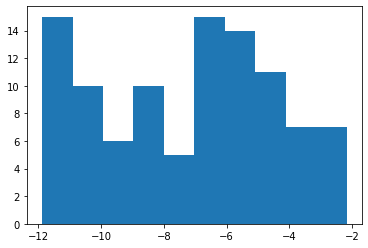

In [18]:
plt.hist(ls_list)

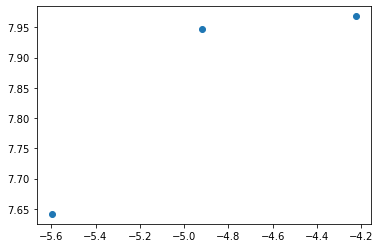

In [19]:
plt.scatter(np.array(ls_list)[np.array(w_list)>0.0002],np.array(sg_list)[np.array(w_list) >.0002])

In [20]:
np.array(sg_list)[np.array(w_list) >.002]

array([7.96834483, 7.94794268])

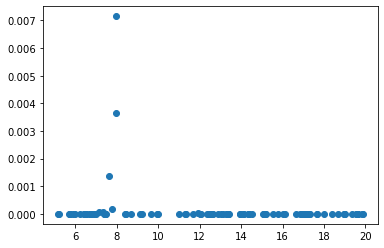

In [21]:
plt.scatter(sg_list,w_list)

(array([1.61784037e-05, 3.52729729e-14, 1.00564634e-25, 7.03240139e-28,
        7.90212716e-28, 3.44666587e-28, 3.35929569e-23, 4.21214091e-25,
        0.00000000e+00, 1.53177404e-24, 4.34453637e-04, 2.28990337e-04,
        2.45036196e-01, 2.37663096e-04, 1.17911584e+00, 6.33909444e-01,
        7.97579138e-07, 1.22868158e-10, 6.77940043e-14, 3.64153830e-03]),
 array([-11.87848924, -11.39366922, -10.9088492 , -10.42402918,
         -9.93920917,  -9.45438915,  -8.96956913,  -8.48474911,
         -7.99992909,  -7.51510907,  -7.03028905,  -6.54546903,
         -6.06064901,  -5.57582899,  -5.09100898,  -4.60618896,
         -4.12136894,  -3.63654892,  -3.1517289 ,  -2.66690888,
         -2.18208886]),
 <BarContainer object of 20 artists>)

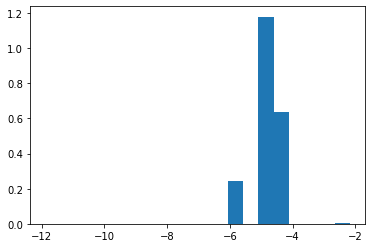

In [22]:
plt.hist(np.array(ls_list), density = True, weights = np.array(w_list), bins = 20)

(array([1.06754262e-05, 2.86677094e-04, 1.27179839e-02, 1.34545851e+00,
        2.21394982e-23, 7.71516970e-04, 1.80394542e-26, 4.47343202e-14,
        8.81418458e-06, 1.77956432e-03, 3.15158989e-07, 5.41031814e-08,
        6.33930623e-11, 6.80972042e-18, 4.10069002e-16, 2.77940919e-25,
        8.19187562e-17, 8.10749532e-11, 3.81166918e-22, 1.29025848e-23]),
 array([ 5.16853937,  5.90327482,  6.63801026,  7.3727457 ,  8.10748114,
         8.84221658,  9.57695202, 10.31168746, 11.0464229 , 11.78115834,
        12.51589378, 13.25062923, 13.98536467, 14.72010011, 15.45483555,
        16.18957099, 16.92430643, 17.65904187, 18.39377731, 19.12851275,
        19.8632482 ]),
 <BarContainer object of 20 artists>)

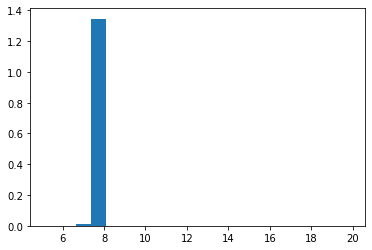

In [23]:
plt.hist(np.array(sg_list), density = True, weights = np.array(w_list), bins = 20)

In [24]:
plt.hist(np.array(br_list), density = True, weights = np.array(w_list), bins = 20)

NameError: name 'br_list' is not defined

(array([2.65222613e-02, 2.22043165e+00, 9.35891274e-02, 5.94103960e+00,
        6.66769963e-13, 1.59118405e-04, 9.16207290e-03, 2.17794812e-19,
        8.75088345e-21, 7.77158527e-27, 2.95945884e-01, 5.28682280e-13,
        1.16011543e+01, 1.31376391e-04, 3.29992240e-22, 5.04011338e-18,
        2.24364647e-03, 3.29925605e-06, 2.34056774e-06, 9.59785201e-02]),
 array([0.00928672, 0.05858092, 0.10787511, 0.15716931, 0.20646351,
        0.25575771, 0.3050519 , 0.3543461 , 0.4036403 , 0.4529345 ,
        0.5022287 , 0.55152289, 0.60081709, 0.65011129, 0.69940549,
        0.74869969, 0.79799388, 0.84728808, 0.89658228, 0.94587648,
        0.99517067]),
 <BarContainer object of 20 artists>)

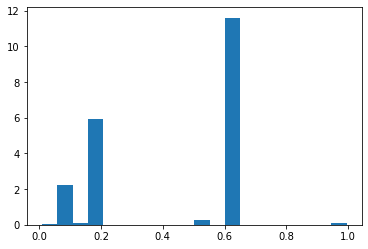

In [25]:
plt.hist(np.array(p_fw_list), density = True, weights = np.array(w_list), bins = 20)

(array([1.20617307e-09, 4.26342183e-03, 5.12619767e-19, 1.89095891e-01,
        3.65994309e-26, 2.64581043e-02, 1.58733496e-04, 1.88618416e-22,
        5.92666828e+00, 2.33650410e-03, 9.27312938e-03, 2.23821911e-03,
        8.72975983e-21, 2.92898176e-01, 1.15688309e+01, 1.21803566e-15,
        2.21506044e+00, 2.92854812e-59, 8.50667194e-06, 3.25013490e-07]),
 array([0.00212454, 0.05153827, 0.100952  , 0.15036573, 0.19977946,
        0.24919318, 0.29860691, 0.34802064, 0.39743437, 0.4468481 ,
        0.49626183, 0.54567556, 0.59508929, 0.64450302, 0.69391675,
        0.74333048, 0.79274421, 0.84215794, 0.89157166, 0.94098539,
        0.99039912]),
 <BarContainer object of 20 artists>)

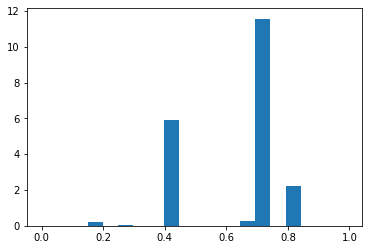

In [26]:
plt.hist(np.array(el_list), density = True, weights = np.array(w_list), bins = 20)

(array([1.60042716e-04, 9.34710217e-03, 2.95313823e-01, 8.90580158e-33,
        8.57682982e-06, 6.00222417e+00, 1.21545021e-09, 2.35104949e-03,
        9.65360055e-02, 5.46921575e-19, 9.94818579e-25, 2.23332973e+00,
        5.06938880e-18, 9.41194340e-02, 2.25918496e-03, 4.72468124e-06,
        6.14246392e-15, 4.29777286e-03, 2.68186004e-06, 1.16642413e+01]),
 array([0.00908121, 0.05809074, 0.10710027, 0.1561098 , 0.20511933,
        0.25412886, 0.30313838, 0.35214791, 0.40115744, 0.45016697,
        0.4991765 , 0.54818603, 0.59719555, 0.64620508, 0.69521461,
        0.74422414, 0.79323367, 0.8422432 , 0.89125272, 0.94026225,
        0.98927178]),
 <BarContainer object of 20 artists>)

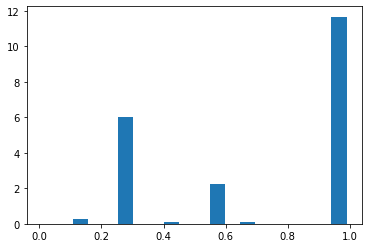

In [27]:
plt.hist(np.array(er_list), density = True, weights = np.array(w_list), bins = 20)

In [28]:
thinning_prob = norm.cdf(10.0/ (np.dot(w_list,sg_list)/np.sum(w_list)))
fw_br = np.minimum(fw_contexts/(1.0-thinning_prob),1.0)
rc_br = np.minimum(rc_contexts/(1.0-thinning_prob),1.0)
post_mean_params = { "lengthscale" : (np.dot(w_list,ls_list)/np.sum(w_list)),
                       "gp_sigma" : np.dot(w_list,sg_list)/np.sum(w_list),
                       "gp_ridge" : .01,
            "gp_offset": -10.0,
            "p_fw": np.dot(w_list, p_fw_list)/np.sum(w_list),
            "fw_br": fw_br,
            "rc_br": rc_br,
            "exo_left": np.dot(w_list, el_list)/np.sum(w_list),
            "exo_right": np.dot(w_list, er_list)/np.sum(w_list),
            "ber_prob": np.dot(w_list, p_ber_list)/np.sum(w_list)
            }
post_mean_params

{'lengthscale': -4.7856339597573445,
 'gp_sigma': 7.916837054804955,
 'gp_ridge': 0.01,
 'gp_offset': -10.0,
 'p_fw': 0.43149934841930165,
 'fw_br': array([0.00119486, 0.00119486, 0.00119486, 0.00119486, 0.00119486,
        1.        , 0.00119486, 0.00119486, 0.00119486, 0.00119486,
        0.00119486, 0.00119486, 0.00119486, 0.00119486, 1.        ,
        0.00119486, 0.00119486, 1.        , 0.00119486, 0.00119486,
        0.45649611, 0.00119486, 1.        , 1.        , 0.00119486,
        0.00119486, 0.00119486, 0.00119486, 0.00119486, 0.45649611,
        0.00119486, 0.00119486, 0.00119486, 0.00119486, 0.00119486,
        0.00119486, 1.        , 0.00119486, 0.00119486, 0.00119486,
        0.00119486, 1.        , 1.        , 0.00119486, 0.00119486,
        0.00119486, 1.        , 0.00119486, 1.        , 0.00119486,
        0.00119486, 0.00119486, 0.00119486, 0.00119486, 1.        ,
        0.00119486, 0.81867483, 0.00119486, 1.        , 0.00119486,
        0.00119486, 0.00119486, 1.  

In [30]:
sample = gen_batch_letters(germline, 5000, post_mean_params)

In [31]:
sample_bp = (1.0-np.mean(np.array(sample) == germline, axis = 0))

In [32]:
sample_colocal = get_colocal(sample,germline, sample_bp,50)

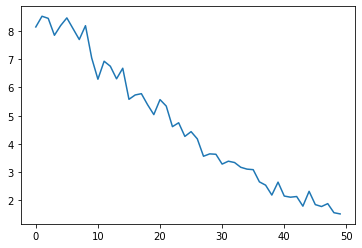

In [33]:
plt.plot(sample_colocal)

In [36]:
base_prob = (1.0-np.mean(seqs == np.array(list(germline)), axis = 0))
colocals = get_colocal(seqs,germline,base_prob,50)

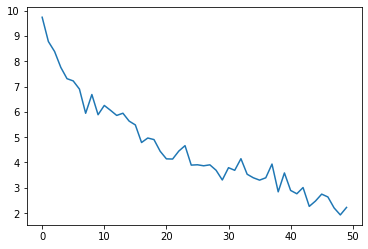

In [37]:
plt.plot(colocals)

In [51]:
pos_mut_obs = np.zeros(308)
pos_mut_sample = np.zeros(308)
sample = np.array(sample)
for i in range(2242):
    for j in range(308):
        pos_mut_obs[j] = pos_mut_obs[j] + float(seqs[i,j] == germline[j]) 
pos_mut_obs = 1-pos_mut_obs/2242

for i in range(5000):
    for j in range(308):
       pos_mut_sample[j] = pos_mut_sample[j] + float(sample[i,j] == germline[j]) 
pos_mut_sample = 1-pos_mut_sample/5000

In [56]:
np.corrcoef((fw_contexts+rc_contexts)/2.0, pos_mut_sample)

array([[1.        , 0.21403304],
       [0.21403304, 1.        ]])

In [58]:
np.corrcoef((fw_contexts+rc_contexts)/2.0, pos_mut_obs)

array([[1.        , 0.20580618],
       [0.20580618, 1.        ]])

In [59]:
np.corrcoef(pos_mut_sample, pos_mut_obs)

array([[ 1.        , -0.01835546],
       [-0.01835546,  1.        ]])

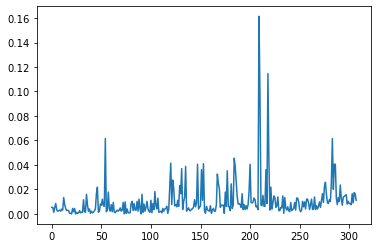

In [60]:
plt.plot(pos_mut_obs)

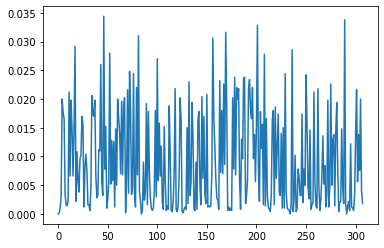

In [61]:
plt.plot(pos_mut_sample)

In [67]:
np.argmax(pos_mut_sample)

46

In [68]:
pos_mut_obs[46]

0.021855486173059768

In [69]:
np.mean(pos_mut_obs)

0.010287660599881834